In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
LR_DQN = 0.0003
LR_RND = 0.0003
UP_COEF = 0.1
EX_COEF = 2.0
IN_COEF = 1.0
GAMMA = 0.99
EPS = 1e-8

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU(),
#             nn.Linear(256, 256),
#             nn.SELU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q


class RandomNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 512)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature


class PredictNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 512)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature

In [4]:
m_losses = []
f_losses = []
losses = []

def learn(net, tgt_net, pred_net, rand_net, net_optim, pred_optim, rep_memory):
    global mean
    global std

    net.train()
    tgt_net.train()
    pred_net.train()
    rand_net.train()

    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))

    dataloader = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda
    )

    # double DQN
    for i, (s, a, r_ex, r_in, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()

        _s_norm = normalize_obs(_s.detach().cpu().numpy(), mean, std)
        _s_norm_batch = torch.tensor(_s_norm).to(device).float()
        r_ex_batch = r_ex.to(device).float()
        r_in_batch = r_in.to(device).float()
        r_batch = EX_COEF * 0.5 * r_ex_batch + IN_COEF * 0.5 * r_in_batch
        done_mask = 1. - d.to(device).float()

        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)
        pred_features = pred_net(_s_norm_batch)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            action_space = _q_batch_tgt.shape[1]
            _q_best_tgt = _q_batch_tgt[range(BATCH_SIZE), _a_batch]
            rand_features = rand_net(_s_norm_batch)

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        m_loss = ((r_batch + GAMMA * done_mask *_q_best_tgt) - q_acting).pow(2).mean()
        m_losses.append(m_loss)

        f_loss = (pred_features - rand_features).pow(2).sum(dim=1).mean()
        f_losses.append(f_loss)

        loss = m_loss + f_loss
        losses.append(loss)
        
        net_optim.zero_grad()
        pred_optim.zero_grad()
        
        loss.backward()
        
        net_optim.step()
        pred_optim.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = target_net(state)
        action = torch.argmax(q)

    return action.item()


def get_norm_params(obs_memory):
    global obs_apace

    obses = [[] for _ in range(obs_space)]
    for obs in obs_memory:
        for j in range(obs_space):
            obses[j].append(obs[j])

    mean = np.zeros(obs_space, np.float32)
    std = np.zeros(obs_space, np.float32)
    for i, obs_ in enumerate(obses):
        mean[i] = np.mean(obs_)
        std[i] = np.std(obs_)
    return mean, std


def normalize_obs(obs, mean, std):
#     means = [mean for _ in range(BATCH_SIZE)]
#     stds = [std for _ in range(BATCH_SIZE)]
#     mean = np.stack(means)
#     std = np.stack(stds)
    norm_obs = (obs - mean) / std

#     return np.clip(norm_obs, -5, 5)
    return norm_obs


def calculate_reward_in(pred_net, rand_net, obs):
    global mean
    global std

    norm_obs = normalize_obs(obs, mean, std)
    state = torch.tensor([norm_obs]).to(device).float()
    with torch.no_grad():
        pred_obs = pred_net(state)
        rand_obs = rand_net(state)
        reward = (pred_obs - rand_obs).pow(2).sum()
        clipped_reward = torch.clamp(reward, -1, 1)

    return clipped_reward.item()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1600
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
init_steps = 0
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False
is_init_roll = True

# make four nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)
pred_net = PredictNet(obs_space).to(device)
rand_net = RandomNet(obs_space).to(device)

# make optimizer
net_optim = torch.optim.Adam(net.parameters(), lr=LR_DQN, eps=EPS)
pred_optim = torch.optim.Adam(pred_net.parameters(), lr=LR_RND, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)
obs_memory = deque(maxlen=learn_start)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

-110.0

In [10]:
# rollout
while True:
    obs = env.reset()
    done = False
    while not done:
#         env.render()
        action = env.action_space.sample()
        _obs, _, done, _ = env.step(action)
        obs_memory.append(_obs)
        obs = _obs
        init_steps += 1
        if init_steps == learn_start:
            mean, std = get_norm_params(obs_memory)
            obs_memory.clear()
            is_init_roll = False
            break
    if not is_init_roll:
        break

In [11]:
# play!
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    ep_reward_in = 0.
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)
        
        reward_in = calculate_reward_in(pred_net, rand_net, _obs)

        obs_memory.append(_obs)
        rep_memory.append((obs, action, reward, reward_in, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        ep_reward_in += reward_in
        
        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if total_steps % learn_start == 0:
            mean, std = get_norm_params(obs_memory)
        
        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n====================  Start Learning  ====================\n')
                is_learned = True    
            learn(net, target_net, pred_net, rand_net,
                  net_optim, pred_optim, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}, reward_in {:.2f}'.format(
            i, total_steps, ep_reward, ep_reward_in))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'../test/saved_models/{env.spec.id}_ep{i}_clear_model_dddqn_r.pt')
                break
env.close()

  1 Episode in   200 steps, reward -200.00, reward_in 200.00
  2 Episode in   400 steps, reward -200.00, reward_in 200.00
  3 Episode in   600 steps, reward -200.00, reward_in 200.00
  4 Episode in   800 steps, reward -200.00, reward_in 200.00
  5 Episode in  1000 steps, reward -200.00, reward_in 200.00
  6 Episode in  1200 steps, reward -200.00, reward_in 200.00
  7 Episode in  1400 steps, reward -200.00, reward_in 200.00

====================  Start Learning  ====================

  8 Episode in  1600 steps, reward -200.00, reward_in 200.00
  9 Episode in  1800 steps, reward -200.00, reward_in 193.42
 10 Episode in  2000 steps, reward -200.00, reward_in 96.46
 11 Episode in  2200 steps, reward -200.00, reward_in 35.50
 12 Episode in  2400 steps, reward -200.00, reward_in 33.20
 13 Episode in  2600 steps, reward -200.00, reward_in 20.80
 14 Episode in  2800 steps, reward -200.00, reward_in 23.05
 15 Episode in  3000 steps, reward -200.00, reward_in 7.61
 16 Episode in  3200 steps, rew

139 Episode in 22905 steps, reward -136.00, reward_in 0.58
140 Episode in 23068 steps, reward -163.00, reward_in 0.78
141 Episode in 23223 steps, reward -155.00, reward_in 0.80
142 Episode in 23377 steps, reward -154.00, reward_in 0.68
143 Episode in 23519 steps, reward -142.00, reward_in 0.66
144 Episode in 23668 steps, reward -149.00, reward_in 0.89
145 Episode in 23760 steps, reward -92.00, reward_in 0.52
146 Episode in 23934 steps, reward -174.00, reward_in 0.78
147 Episode in 24076 steps, reward -142.00, reward_in 0.87
148 Episode in 24162 steps, reward -86.00, reward_in 0.42
149 Episode in 24321 steps, reward -159.00, reward_in 0.91
150 Episode in 24414 steps, reward -93.00, reward_in 0.44
151 Episode in 24614 steps, reward -200.00, reward_in 0.61
152 Episode in 24752 steps, reward -138.00, reward_in 0.94
153 Episode in 24895 steps, reward -143.00, reward_in 0.80
154 Episode in 25095 steps, reward -200.00, reward_in 0.68
155 Episode in 25230 steps, reward -135.00, reward_in 0.82


279 Episode in 41334 steps, reward -154.00, reward_in 0.40
280 Episode in 41490 steps, reward -156.00, reward_in 0.48
281 Episode in 41644 steps, reward -154.00, reward_in 0.55
282 Episode in 41731 steps, reward -87.00, reward_in 0.23
283 Episode in 41818 steps, reward -87.00, reward_in 0.26
284 Episode in 41965 steps, reward -147.00, reward_in 0.39
285 Episode in 42094 steps, reward -129.00, reward_in 0.35
286 Episode in 42180 steps, reward -86.00, reward_in 0.42
287 Episode in 42329 steps, reward -149.00, reward_in 0.54
288 Episode in 42455 steps, reward -126.00, reward_in 0.33
289 Episode in 42581 steps, reward -126.00, reward_in 0.45
290 Episode in 42747 steps, reward -166.00, reward_in 0.55
291 Episode in 42878 steps, reward -131.00, reward_in 0.23
292 Episode in 42972 steps, reward -94.00, reward_in 0.43
293 Episode in 43061 steps, reward -89.00, reward_in 0.19
294 Episode in 43197 steps, reward -136.00, reward_in 0.45
295 Episode in 43328 steps, reward -131.00, reward_in 0.55
29

419 Episode in 58959 steps, reward -120.00, reward_in 0.44
420 Episode in 59046 steps, reward -87.00, reward_in 0.18
421 Episode in 59159 steps, reward -113.00, reward_in 0.13
422 Episode in 59274 steps, reward -115.00, reward_in 0.75
423 Episode in 59420 steps, reward -146.00, reward_in 0.29
424 Episode in 59532 steps, reward -112.00, reward_in 0.17
425 Episode in 59680 steps, reward -148.00, reward_in 0.32
426 Episode in 59793 steps, reward -113.00, reward_in 0.34
427 Episode in 59914 steps, reward -121.00, reward_in 0.33
428 Episode in 59998 steps, reward -84.00, reward_in 0.13
429 Episode in 60091 steps, reward -93.00, reward_in 0.14
430 Episode in 60237 steps, reward -146.00, reward_in 0.30
431 Episode in 60351 steps, reward -114.00, reward_in 0.32
432 Episode in 60436 steps, reward -85.00, reward_in 0.14
433 Episode in 60522 steps, reward -86.00, reward_in 0.17
434 Episode in 60638 steps, reward -116.00, reward_in 0.30
435 Episode in 60734 steps, reward -96.00, reward_in 0.14
436

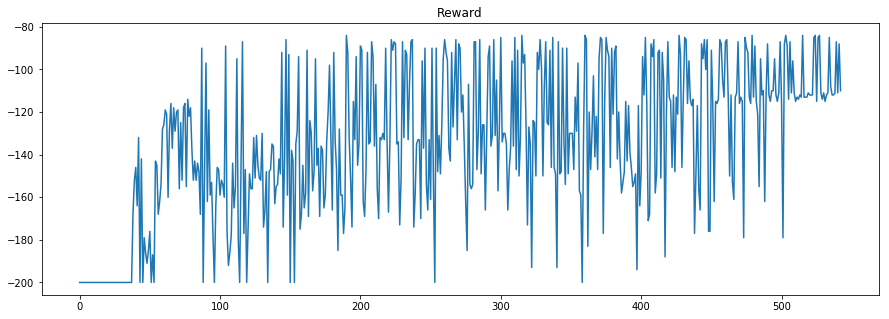

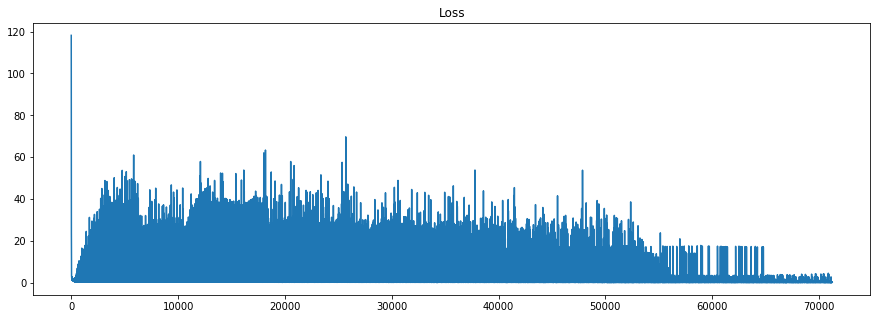

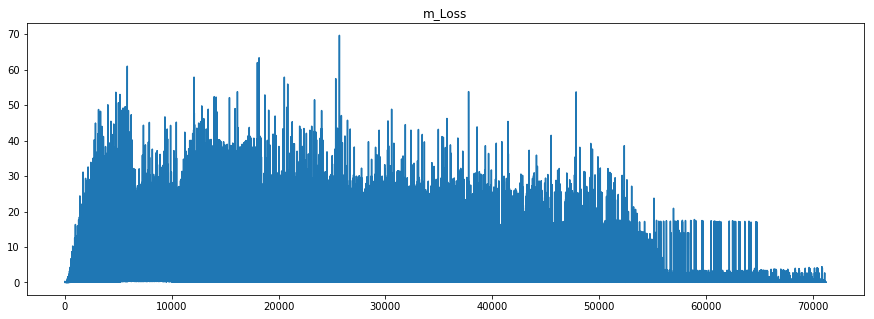

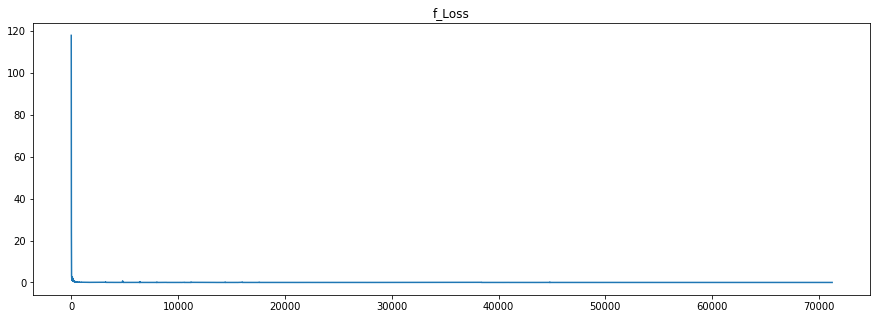

In [12]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.figure(figsize=(15, 5))
plt.title('m_Loss')
plt.plot(m_losses)
plt.figure(figsize=(15, 5))
plt.title('f_Loss')
plt.plot(f_losses)
plt.show()

In [13]:
[
    ('CartPole-v0', 355, 0.5),
    ('CartPole-v1', 484, 0.025),
    ('MountainCar-v0', 571, 0.1),
    ('LunarLander-v2', 454, 0.5)
]

[('CartPole-v0', 355, 0.5),
 ('CartPole-v1', 484, 0.025),
 ('MountainCar-v0', 571, 0.1),
 ('LunarLander-v2', 454, 0.5)]